In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We'll be scraping data off of Remax's website and building a linear regression model to predict house prices based on 3 given features:

    - House area (in squared meters);
    - Number of bedrooms;
    - Number of toilets.

In [153]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time

options = Options()
options.add_experimental_option("detach", True)

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

URL = "https://remax.pt/comprar?searchQueryState=%7B%22regionName%22:%22lisboa%22,%22businessType%22:1,%22page%22:1,%22regionID%22:%22%22,%22regionType%22:%22%22,%22sort%22:%7B%22fieldToSort%22:%22PublishDate%22,%22order%22:1%7D,%22mapIsOpen%22:false%7D"
driver.get(URL)

listings_data = []

while True:
    listings = WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'div.col-12.col-sm-6.col-md-6.col-lg-4.col-xl-3.result'))
    )
    
    for listing in listings:
        # Extract the price
        price = listing.find_element(By.CSS_SELECTOR, 'p.listing-price span').text
    
        # Extract the address
        address = listing.find_element(By.CSS_SELECTOR, 'h2.listing-address span').text
    
        # Extract the square meters
        square_meters = listing.find_element(By.CSS_SELECTOR, 'li.listing-area').text.split()[0]
        
        # Extract the number of bedrooms
        bedrooms = listing.find_element(By.CSS_SELECTOR, 'li.listing-bedroom').text.split()[0]
        
        # Extract the number of bathrooms
        bathrooms = listing.find_element(By.CSS_SELECTOR, 'li.listing-bathroom').text.split()[0]
    
        listings_data.append({
            'Price': price,
            'Square Meters': square_meters,
            'Address': address,
            'Bedrooms': bedrooms,
            'Bathrooms': bathrooms
        })
    
    # Attempt to find the "Next" button; if it's not disabled, click it
    try:
        next_button = driver.find_element(By.CSS_SELECTOR, 'li.arrow.page-item:not(.disabled) a.page-link[role="button"] .icon-right')
        if next_button:
            driver.execute_script("arguments[0].click();", next_button)
            time.sleep(3)  # Wait for the page to load
        else:
            print("Reached the last page.")
            break
    except NoSuchElementException:
        print("No more pages to navigate. Closing driver.")
        break

df = pd.DataFrame(listings_data)

current_date = datetime.now().strftime('%d_%B_%Y')
df.to_csv(f'{current_date}_remax_lisbon_listings.csv')

driver.quit()

No more pages to navigate. Closing driver.


## Data Analysis

In [138]:
df = pd.read_csv('listings.csv')
df

,Price,Square Meters,Address,Bedrooms,Bathrooms
0,460 000 €,--,"Cascais, Alcabideche",--,--
1,490 000 €,--,"Cascais, Alcabideche",--,--
2,247 000 €,72,"Odivelas, Odivelas",3,2
3,540 000 €,72,"Cascais, Cascais e Estoril",2,2
4,350 000 €,130,"Lisboa, Arroios",9,2
...,...,...,...,...,...
1995,399 000 €,130,"Oeiras, Oeiras e São Julião da Barra, Paço de ...",3,2
1996,265 000 €,100,"Lisboa, Arroios",--,2
1997,198 000 €,64,"Sintra, Cacém e São Marcos",2,1
1998,449 000 €,118,"Loures, Santa Iria de Azoia, São João da Talha...",3,2


In [117]:
# -- Data Processing --

# remove rows with missing values (i.e. '--')
df = df.apply(lambda x: x.replace('--', np.nan), axis=0)

# remove spaces and the euro symbol
df['Price'] = df['Price'].apply(lambda x: x.replace(" ", "").replace("€", ""))

# replace 'preçosobconsulta' with NaN to avoid conversion errors
df['Price'] = df['Price'].replace('preçosobconsulta', np.nan)

# convert numerical variables to float
df['Price'] = df['Price'].astype(float)
df['Square Meters'] = df['Square Meters'].astype(float)
df['Bedrooms'] = df['Bedrooms'].astype(float)
df['Bathrooms'] = df['Bathrooms'].astype(float)

In [118]:
# remove rows with missing values
df = df.dropna()

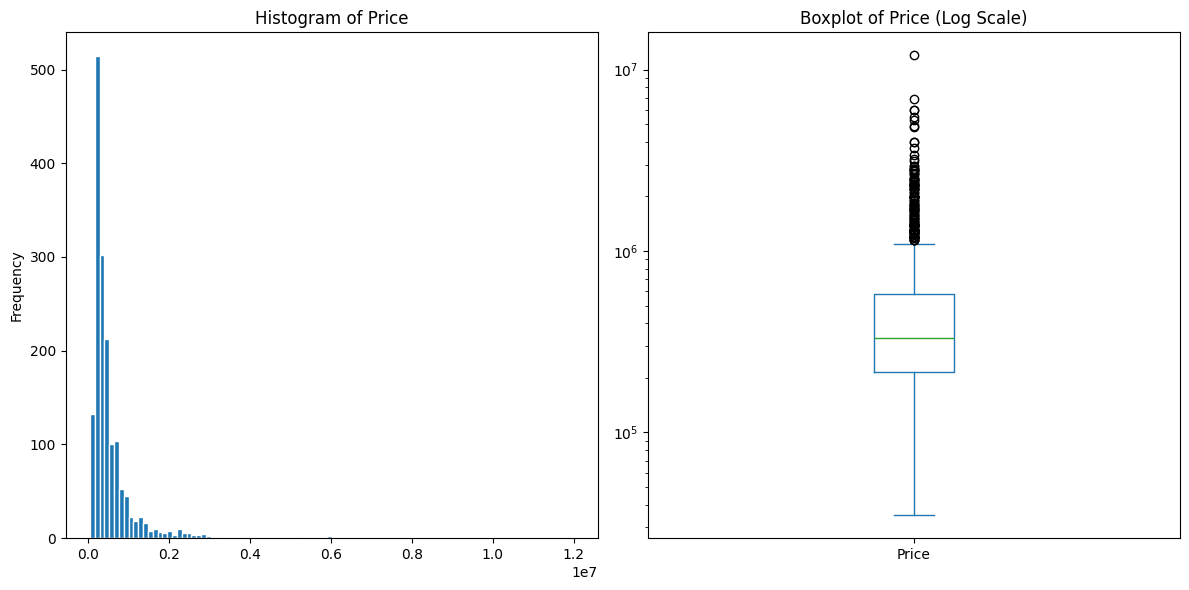

count    1.626000e+03
mean     5.224897e+05
std      6.586582e+05
min      3.500000e+04
25%      2.150000e+05
50%      3.299950e+05
75%      5.800000e+05
max      1.200000e+07
Name: Price, dtype: float64

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram
df.Price.plot(kind='hist', edgecolor='white', bins=100, ax=axs[0])
axs[0].set_title('Histogram of Price')

# Plot boxplot in log scale
df.Price.plot(kind='box', ax=axs[1])
axs[1].set_title('Boxplot of Price (Log Scale)')
axs[1].set_yscale('log')

plt.tight_layout()
plt.show()

df.Price.describe()

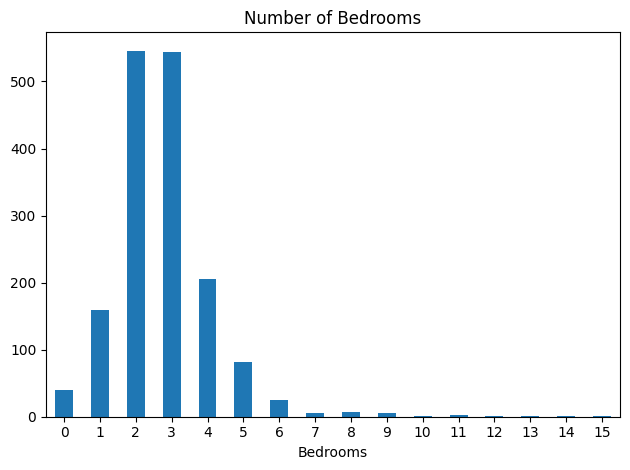

count    1626.000000
mean        2.760763
std         1.417677
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        15.000000
Name: Bedrooms, dtype: float64

In [133]:
# Plot histogram
value_counts = df.Bedrooms.value_counts()
value_counts.index = value_counts.index.astype(int)
value_counts.sort_index().plot(kind='bar')
plt.title('Number of Bedrooms')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

df.Bedrooms.describe()

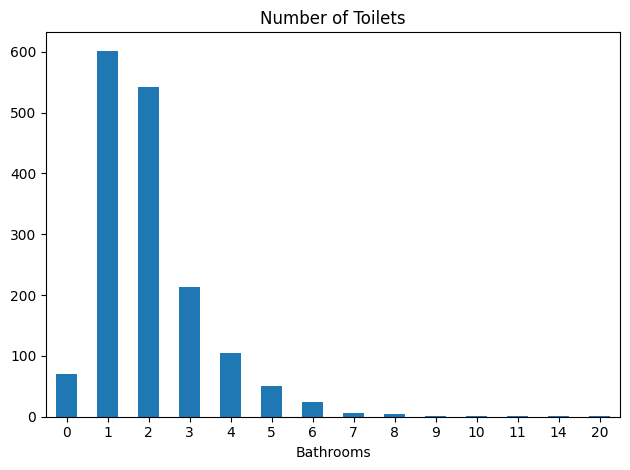

count    1626.000000
mean        2.760763
std         1.417677
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        15.000000
Name: Bedrooms, dtype: float64

In [135]:
# Plot histogram
value_counts = df.Bathrooms.value_counts()
value_counts.index = value_counts.index.astype(int)
value_counts.sort_index().plot(kind='bar')
plt.title('Number of Toilets')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

df.Bedrooms.describe()

## Lisbon House Price Predictor